# Zillow_clustering_Project: Understanding and Improving Zestimate

Glady Barrios

AUG, 9, 2022

Kalpana Cohort

## Project Goal

- Use clustering to algorythims to determine driving errors in the current Zestimate.
- Trying to find and use the differnt drivers of logerror to improve the Zestimate Model.
- Mostly we want to improve the Zestimate model using our diffrent modeling methods.

## Project Description

The goal of this project is to find the driving errors in the Zestimate and find ways to better improve Zillows current models. Improving our models will help zillow customers get more accurate home prices. We want our customers to have the most accurate information



In [17]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing


from wrangle import wrangle_zillow
from prepare import train_validate_test_split, scale_data

from scipy import stats
from math import sqrt

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# wrangle the data

In [2]:
df = wrangle_zillow()
df.head(3)

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,...,transactiondate,propertylandusedesc,County,age,age_bin,acres,acres_bin,LA,Orange,Ventura
0,1727539,14297519,3.5,4.0,6059.0,33634931.0,-117869207.0,4506.0,122,261.0,...,2017-01-01,Single Family Residential,Orange County,19.0,0.133,0.103444,0.1,0,1,0
1,1387261,17052889,1.0,2.0,6111.0,34449266.0,-119281531.0,12647.0,1110,261.0,...,2017-01-01,Single Family Residential,Ventura County,50.0,0.333,0.290335,0.3,0,0,1
2,11677,14186244,2.0,3.0,6059.0,33886168.0,-117823170.0,8432.0,122,261.0,...,2017-01-01,Single Family Residential,Orange County,55.0,0.400,0.193572,0.2,0,1,0


In [3]:
train, validate, test = train_validate_test_split(df)
train.shape, validate.shape, test.shape

((29136, 26), (12488, 26), (10406, 26))

In [4]:
train_s, valid_s, test_s = scale_data(train, validate, test)

# Exploring the data 

## Question 1 - Is log error significantly different for properties in the three counties?

Null hypothesis: Log error will be the same across all three counties.
Alternative hypothesis: Log error will vary based on county

<AxesSubplot:xlabel='County', ylabel='logerror'>

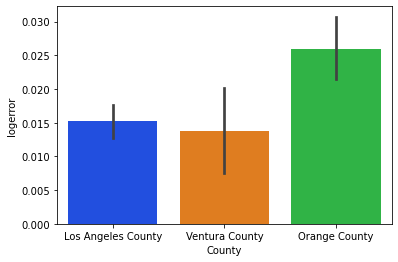

In [6]:
#Compare the average log error between counties
sns.barplot(x='County', y='logerror', data=train, palette= "bright")

In [7]:
#Conduct an ANOVA test between the counties
f_county, p_county = stats.f_oneway(df[df['County'] == 'Los Angeles County'].logerror,
                                    df[df['County'] == 'Orange County'].logerror,
                                    df[df['County'] == 'Ventura County'].logerror)

f_county, p_county

(22.500550909641934, 1.7074916354433785e-10)

In [8]:
#Compare my p value to alpha
alpha = 0.05
if p_county < alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis.


------------------------------------

## Question 2 - Is log error significantly different for properties that have diffrent bathroom counts 

<AxesSubplot:xlabel='bathroomcnt', ylabel='logerror'>

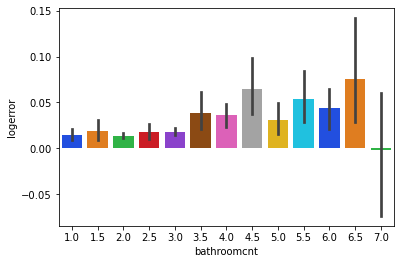

In [9]:
sns.barplot(x='bathroomcnt', y='logerror', data=train, palette= "bright")

---------------------------------

## Question 3 - Is log error significantly different for properties that have diffrent bedroom counts

<AxesSubplot:xlabel='bedroomcnt', ylabel='logerror'>

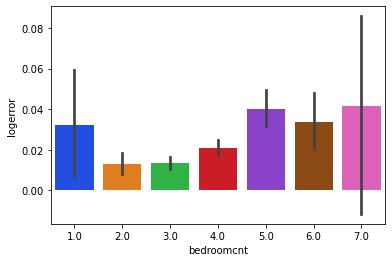

In [10]:
sns.barplot(x='bedroomcnt', y='logerror', data=train, palette= "bright")

-------------------------------

## Question 4 -  Is log error significantly different for properties that have diffrent proprty values

<AxesSubplot:xlabel='taxvaluedollarcnt', ylabel='logerror'>

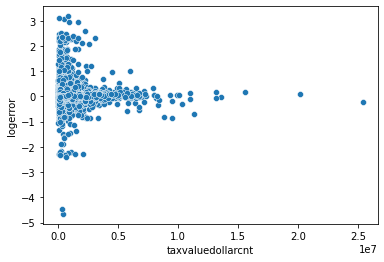

In [11]:
sns.scatterplot(x='taxvaluedollarcnt', y='logerror', data=train, palette= "bright")

Null hypothesis: There is no correlation between price and log error.
    
Alternative hypothesis: There is a relationship between price and log error.

In [12]:
#Test for correlation between the two
corr_value, p_value = stats.pearsonr(df['taxvaluedollarcnt'],
                                     df['logerror'])

corr_value, p_value

(-0.006149787116911295, 0.16069102565002474)

In [13]:
#Test my hypothesis
if p_value < alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

We fail to reject the null hypothesis.


## Clustering

### First cluster - size= bed bath, sqft

In [14]:
X = train_s[['bathroomcnt', 'bedroomcnt','lotsizesquarefeet']]
X.head()

,bathroomcnt,bedroomcnt,lotsizesquarefeet
34264,0.500000,0.500000,0.008265
8237,0.166667,0.166667,0.014113
31640,0.166667,0.333333,0.019604
14309,0.166667,0.333333,0.009377
50710,0.500000,0.333333,0.212281


In [69]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

clusters = kmeans.predict(X)
clusters

array([1, 2, 0, ..., 0, 3, 0], dtype=int32)

In [70]:
train_s['size_cluster'] = clusters


<AxesSubplot:xlabel='bathroomcnt', ylabel='bedroomcnt'>

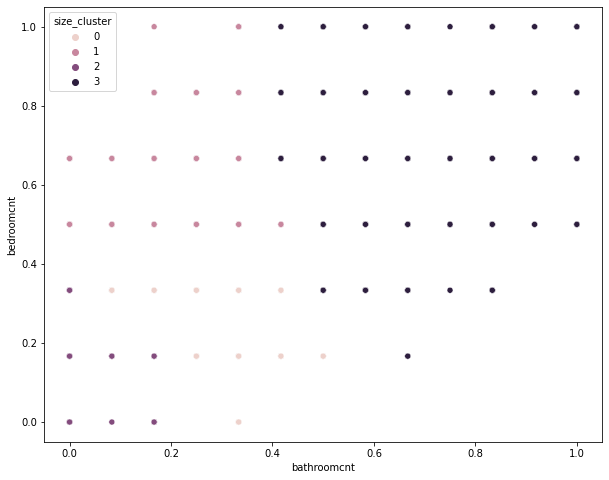

In [61]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=train_s, x='bathroomcnt', y='bedroomcnt', hue = 'size_cluster')


In [71]:
kmeans.cluster_centers_

array([[0.20636963, 0.32878897, 0.01143319],
       [0.58584956, 0.59164349, 0.0237971 ],
       [0.03791556, 0.20881142, 0.01000254],
       [0.25686106, 0.52542405, 0.01271542]])

In [72]:
centroids2 = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

Text(0.5, 1.0, 'Visualizing Cluster Centers')

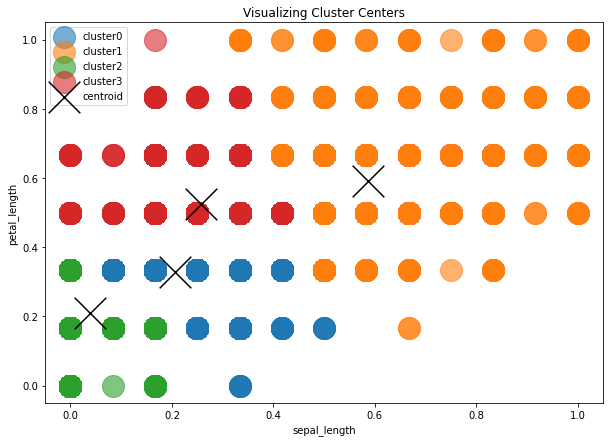

In [74]:
plt.figure(figsize=(10, 7))

for cluster, subset in train_s.groupby('size_cluster'):
    plt.scatter(subset.bathroomcnt, subset.bedroomcnt, label='cluster' + str(cluster), alpha=.6, s=22**2)

centroids2.plot.scatter(y='bedroomcnt', x='bathroomcnt', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.title('Visualizing Cluster Centers')


In [ ]:
Anova test

--------------------------------

### second cluster - locations- log lat 

In [22]:
L = train_s[['latitude', 'longitude']]
L.head()

,latitude,longitude
34264,0.290645,0.705217
8237,0.477749,0.697542
31640,0.559977,0.271079
14309,0.559026,0.279767
50710,0.688996,0.084830


In [23]:
kmeans1 = KMeans(n_clusters=4)
kmeans1.fit(L)

clusters = kmeans1.predict(L)
clusters

array([1, 1, 0, ..., 3, 0, 2], dtype=int32)

In [24]:
train_s['location_cluster'] = clusters
train_s.head()

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,...,County,age,age_bin,acres,acres_bin,LA,Orange,Ventura,size_cluster,location_cluster
34264,2036202,12529787,0.500000,0.500000,6037.0,0.290645,0.705217,0.008265,0101,261.0,...,Los Angeles County,52.0,0.400,0.150826,0.2,1,0,0,3,1
8237,2883002,11848044,0.166667,0.166667,6037.0,0.477749,0.697542,0.014113,0101,261.0,...,Los Angeles County,65.0,0.466,0.253696,0.3,1,0,0,2,1
31640,2759592,17271234,0.166667,0.333333,6111.0,0.559977,0.271079,0.019604,1111,261.0,...,Ventura County,33.0,0.266,0.350298,0.3,0,0,1,0,0
14309,1044874,17266806,0.166667,0.333333,6111.0,0.559026,0.279767,0.009377,1111,261.0,...,Ventura County,46.0,0.333,0.170386,0.2,0,0,1,0,0
50710,2848400,17068575,0.500000,0.333333,6111.0,0.688996,0.084830,0.212281,1110,261.0,...,Ventura County,28.0,0.200,3.739991,0.5,0,0,1,3,0


In [25]:
kmeans1.cluster_centers_


array([[0.60670378, 0.41710912],
       [0.43695788, 0.69066387],
       [0.23868241, 0.86602011],
       [0.86706856, 0.700474  ]])

In [26]:
centroids = pd.DataFrame(kmeans1.cluster_centers_, columns=L.columns)


Text(0.5, 1.0, 'Visualizing Cluster Centers')

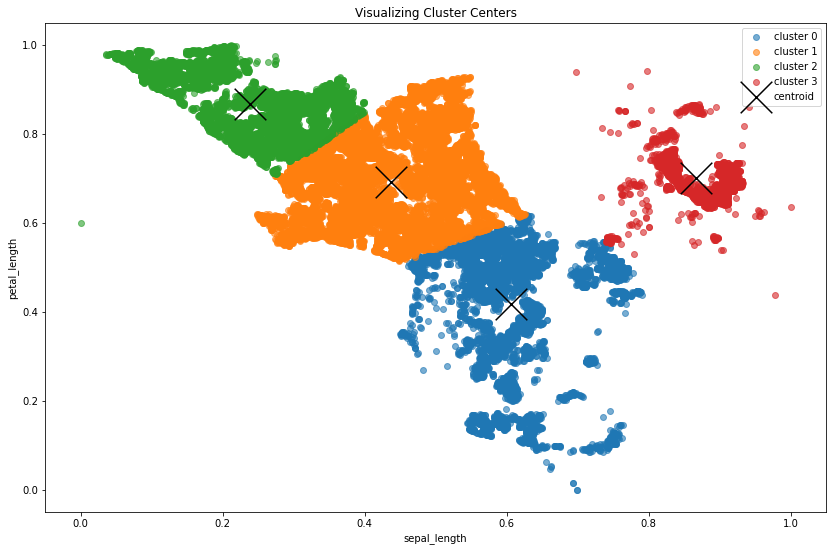

In [27]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_s.groupby('location_cluster'):
    plt.scatter(subset.latitude, subset.longitude, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='longitude', x='latitude', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.title('Visualizing Cluster Centers')


In [ ]:
anova test

-----------------------

## third custer -size and age cluster -  age  and lotsize 

In [34]:
A = train_s[['lotsizesquarefeet', 'age']]


In [29]:
kmeans2 = KMeans(n_clusters=4)
kmeans2.fit(A)

clusters = kmeans2.predict(A)
clusters

array([0, 3, 2, ..., 3, 2, 2], dtype=int32)

In [30]:
train_s['age_size'] = clusters

In [31]:
kmeans2.cluster_centers_

array([[1.24997980e-02, 4.72437579e+01],
       [9.13957851e-03, 9.33958084e+01],
       [1.60035188e-02, 2.11845292e+01],
       [1.15769239e-02, 6.54851687e+01]])

In [32]:
centroids2 = pd.DataFrame(kmeans2.cluster_centers_, columns=A.columns)


Text(0.5, 1.0, 'Visualizing Cluster Centers')

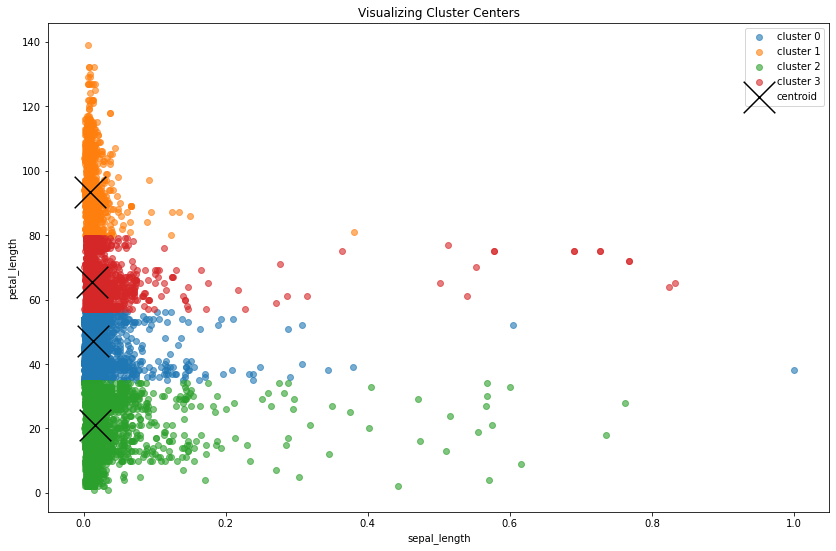

In [33]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_s.groupby('age_size'):
    plt.scatter(subset.lotsizesquarefeet, subset.age, label='cluster ' + str(cluster), alpha=.6)

centroids2.plot.scatter(y='age', x='lotsizesquarefeet', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.title('Visualizing Cluster Centers')

In [ ]:
Anova test

## Feature Engennering Using select k best to find the best fetures for modeling

In [35]:
X_train = train_s[['bathroomcnt','bedroomcnt','latitude', 'longitude','lotsizesquarefeet', 'age','acres','LA','Orange','Ventura']]
y_train = pd.DataFrame(train[['logerror']])


X_validate = valid_s[['bathroomcnt','bedroomcnt','latitude', 'longitude','lotsizesquarefeet', 'age','acres','LA','Orange','Ventura']]
y_validate = pd.DataFrame(validate[['logerror']])


X_test = test_s[['bathroomcnt','bedroomcnt','latitude', 'longitude','lotsizesquarefeet', 'age','acres','LA','Orange','Ventura']]
y_test = pd.DataFrame(test[['logerror']])

In [36]:
kbest = SelectKBest(f_regression, k=6)
kbest.fit(X_train, y_train)

SelectKBest(k=6, score_func=<function f_regression at 0x134bbc4c0>)

In [37]:
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=X_train.columns)
kbest_results

,p,f
bathroomcnt,5.195997e-09,34.135166
bedroomcnt,2.730687e-08,30.906959
latitude,9.085502e-05,15.322118
longitude,6.072144e-05,16.084730
lotsizesquarefeet,1.800570e-01,1.797240
age,1.547987e-03,10.022500
acres,1.800570e-01,1.797240
LA,3.367811e-04,12.856932
Orange,3.788513e-06,21.377186
Ventura,2.216195e-01,1.493918


In [38]:
X_train.columns[kbest.get_support()]

Index(['bathroomcnt', 'bedroomcnt', 'latitude', 'longitude', 'LA', 'Orange'], dtype='object')

## Modeling

In [39]:
X_train = train_s[['bathroomcnt','bedroomcnt','latitude', 'longitude']]
y_train = pd.DataFrame(train[['logerror']])


X_validate = valid_s[['bathroomcnt','bedroomcnt','latitude', 'longitude']]
y_validate = pd.DataFrame(validate[['logerror']])


X_test = test_s[['bathroomcnt','bedroomcnt','latitude', 'longitude']]
y_test = pd.DataFrame(test[['logerror']])

In [40]:
from math import sqrt
from sklearn.metrics import mean_squared_error
#Establish baselines for the train and validation subsets
baseline = train.logerror.mean()

train['baseline'] = baseline
validate['baseline'] = baseline

train_rmse = sqrt(mean_squared_error(train.logerror, train.baseline))
valid_rmse = sqrt(mean_squared_error(validate.logerror, validate.baseline))

print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(valid_rmse))

Train baseline RMSE: 0.17902282261997393.
Validation baseline RMSE: 0.16293244362415202.


OLS

In [41]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train['logerror'])

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['logerror'], y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1788394195711862 
Validation/Out-of-Sample:  0.162695056693868


Lasso lars

In [42]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train['logerror'])

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['logerror'], y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.17902282261997393 
Validation/Out-of-Sample:  0.16293244362415202


Polynomial 

In [43]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [44]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train['logerror'])

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['logerror'], y_train.logerror_pred_lm2)**(1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.17878117616995837 
Validation/Out-of-Sample:  0.16267885857439796


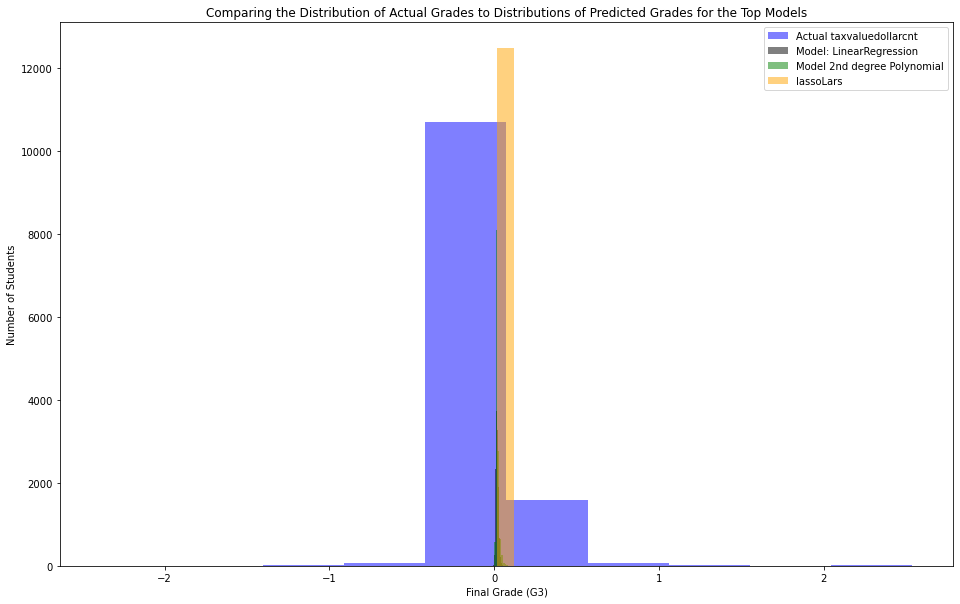

In [45]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,10))
plt.hist(y_validate.logerror, color='blue', alpha=.5, label="Actual taxvaluedollarcnt")
plt.hist(y_validate.logerror_pred_lm, color='black', alpha=.5, label="Model: LinearRegression")
#plt.hist(y_validate.tax_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.logerror_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.hist(y_validate.logerror_pred_lars, color='orange', alpha=.5, label="lassoLars")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual Grades to Distributions of Predicted Grades for the Top Models")
plt.legend()
plt.show()

# Conclusion

## Recomendations

## Next Steps